In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Creación de base de datos y guardado de DataFrame

In [4]:
# Crear una conexión a la base de datos
conn = sql.connect('ecommerce_database.db')

# Crear un cursor
cursor = conn.cursor()

In [5]:
#Crear tablas
create_table_query='''
    CREATE TABLE IF NOT EXISTS customers (
    customer_id TEXT PRIMARY KEY,
    customer_unique_id TEXT,
    customer_zip_code_prefix INTEGER,
    customer_city TEXT,
    customer_state TEXT
);
    CREATE TABLE IF NOT EXISTS order_items (
    order_id TEXT,
    order_item_id INTEGER,
    product_id TEXT,
    seller_id TEXT,
    shipping_limit_date TEXT,
    price REAL,
    freight_value REAL,
    PRIMARY KEY (order_id, order_item_id)
);
    CREATE TABLE IF NOT EXISTS order_payments (
    order_id TEXT,
    payment_sequential INTEGER,
    payment_type TEXT,
    payment_installments INTEGER,
    payment_value REAL,
    PRIMARY KEY(order_id,payment_sequential)
);
    CREATE TABLE IF NOT EXISTS orders (
    order_id TEXT PRIMARY KEY,
    customer_id TEXT,
    order_status TEXT,
    order_purchase_timestamp TEXT,
    order_approved_at TEXT,
    order_delivered_carrier_date TEXT,
    order_delivered_customer_date TEXT,
    order_estimated_delivery_date TEXT
);
    CREATE TABLE IF NOT EXISTS products (
    product_id TEXT PRIMARY KEY,
    product_category_name TEXT,
    product_name_lenght REAL,
    product_description_lenght REAL,
    product_photos_qty REAL,
    product_weight_g REAL,
    product_length_cm REAL,
    product_height_cm REAL,
    product_width_cm REAL
);
'''

cursor.executescript(create_table_query)
conn.commit()

# Realizar las siguientes actividades con Pandas

○ Cargar los archivos CSV en DataFrames de Pandas

In [6]:
#Leer los archivos y guardar los df en la BBDD
customers_df = pd.read_csv('ecommerce_customers_dataset.csv')
orders_df = pd.read_csv('ecommerce_orders_dataset.csv')
order_items_df = pd.read_csv('ecommerce_order_items_dataset.csv')
products_df = pd.read_csv('ecommerce_products_dataset.csv')
order_payments_df = pd.read_csv('ecommerce_order_payments_dataset.csv')


In [ ]:
# Insertar datos
customers_df.to_sql('customers', conn, index=True, if_exists='replace')
order_items_df.to_sql('order_items', conn, index=True, if_exists='replace')
order_payments_df.to_sql('order_payments', conn, index=True, if_exists='replace')
orders_df.to_sql('orders', conn, index=True, if_exists='replace')
products_df.to_sql('products', conn, index=True, if_exists='replace')


○ Establecer la columna índices de las tablas como la clave primaria en el DataFrame, ejemplo para customers la clave será customer_id.

In [8]:
# Establecer la columna índice como clave primaria
customers_df.set_index('customer_id', inplace=True)
orders_df.set_index('order_id', inplace=True)
order_items_df.set_index('order_item_id', inplace=True)
products_df.set_index('product_id', inplace=True)
order_payments_df.set_index('order_id', inplace=True)

In [9]:
print(f'''Indices de Tablas:
Tabla Customers: '{customers_df.index.name}'
Tabla Orders: '{orders_df.index.name}'
Tabla Order Items: '{order_items_df.index.name}'
Tabla Products: '{products_df.index.name}'
Tabla Order Payments: '{order_payments_df.index.name}'
''')

Indices de Tablas:
Tabla Customers: 'customer_id'
Tabla Orders: 'order_id'
Tabla Order Items: 'order_item_id'
Tabla Products: 'product_id'
Tabla Order Payments: 'order_id'



○ Obtener el número total de clientes únicos en el conjunto de datos

In [212]:
total_clientes_unicos = customers_df['customer_unique_id'].nunique()
print(f'El número total de clientes únicos es: {total_clientes_unicos}')


El número total de clientes únicos es: 96096


○ Calcular el promedio de valor de pago por pedido - MODIFICADO

Se realizó el calculo de "valor promedio de los pedidos por ciudad", dado que realizar un promedio de un unico valor daria como resultado ese mismo valor, por lo cual, no aportaria ningún analisis enriquecedor.

In [ ]:
#Realice un merge de la tablas orders_df, order_payments_df y customer_df para
#obtener el valor promedio de los pedidos por ciudad.

merged_df2 = pd.merge(orders_df, order_payments_df, how ='inner', left_on='order_id', right_on='order_id')
merged_df2
merged_df3 = pd.merge(merged_df2, customers_df, how ='inner', left_on ='customer_id', right_on= 'customer_id')
merged_df3

promedio_pago_ciudad = merged_df3.groupby('customer_city')['payment_value'].mean().sort_values(ascending=False).reset_index()

#Redondeo a dos y cambio nombre a columna
promedio_pago_ciudad['payment_value'] = promedio_pago_ciudad['payment_value'].round(2)
promedio_pago_ciudad = promedio_pago_ciudad.rename(columns={'payment_value' : 'valor_promedio_pedido'})

promedio_pago_ciudad

○ Determinar la categoría de producto más vendida

In [12]:
merged_df = pd.merge(products_df, order_items_df, how ='inner', left_on='product_id', right_on='product_id')
categoria_mas_vendida = merged_df['product_category_name'].value_counts().head(1)

print(f'La categoría más vendida es: {categoria_mas_vendida.index[0]}')


La categoría más vendida es: cama_mesa_banho


○ Calcular el número total de pedidos realizados

In [13]:
total_pedidos = orders_df['order_status'].count()
print(f'El número total de pedidos realizados es: {total_pedidos}')

El número total de pedidos realizados es: 99441


#Consulta Pragma

Ejecutar una consulta PRAGMA para obtener la estructura de las tablas y guardar la info a un archivo con extensión .info.

In [ ]:
with open('./estructuras_tablas.info', 'w') as file:
    for estructura in cursor.execute('pragma table_info(customers);').fetchall():
        print(estructura, file=file)

Obtener los nombres de los índices de las tablas y guardar la info a un archivo con extensión .info.

In [ ]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
nombre_tablas = cursor.fetchall()

with open('indices_tablas.info', 'w') as file:
    for tabla in nombre_tablas:
        tabla = tabla[0]
        pragma_query = f"PRAGMA index_list({tabla});"
        cursor.execute(pragma_query)
        index_info = cursor.fetchall()

        file.write(f"Índices de la tabla '{tabla}':\n")
        for index in index_info:
            print(index, file=file)

# Analisis comportamiento de compra de los clientes

● Utilizando los datos de las tablas customers, orders y
order_items.

● Calcula el valor promedio de los pedidos realizados por cada cliente.

In [213]:
precio_promedio_pedido_query = '''
SELECT
  c.customer_unique_id, AVG(oi.price + oi.freight_value) AS precio_orden_promedio
  FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
  GROUP BY c.customer_unique_id
  ORDER BY precio_orden_promedio DESC
  LIMIT 10
'''
precio_promedio_pedido = pd.read_sql_query(precio_promedio_pedido_query, conn)
precio_promedio_pedido

precio_promedio_pedido.to_csv('precios_promedio_pedido.csv', index=False)

● Identifica a los clientes con los pedidos de mayor valor.

In [214]:
#Top 10 clientes con pedidos de mayor valor

clientes_mayores_compras_query = '''
SELECT
  c.customer_unique_id, sum(oi.price + oi.freight_value) AS precio_total
  FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
  GROUP BY c.customer_unique_id
  ORDER BY precio_total DESC
  LIMIT 10
'''
clientes_mayores_compras = pd.read_sql_query(clientes_mayores_compras_query, conn)

clientes_mayores_compras

,customer_unique_id,precio_total
0,0a0a92112bd4c708ca5fde585afaa872,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,7571.63
2,763c8b1c9c68a0229c42c9fc6f662b93,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,6929.31
4,459bef486812aa25204be022145caa62,6922.21
5,ff4159b92c40ebe40454e3e6a7c35ed6,6726.66
6,4007669dec559734d6f53e029e360987,6081.54
7,5d0a2980b292d049061542014e8960bf,4809.44
8,eebb5dda148d3893cdaf5b5ca3040ccb,4764.34
9,48e1ac109decbb87765a3eade6854098,4681.78


In [215]:
clientes_mayores_compras.to_csv('clientes_mayores_compras.csv', index=False)

● Calcular la frecuencia promedio de compra por cliente, es decir, la cantidad de pedidos realizados en un período de tiempo determinado.

In [216]:
# Se calcula la frecuencia, teniendo solamente en cuenta los casos que se realizaron mas de un pedido.

frecuencia_promedio_query = '''
SELECT c.customer_unique_id, count(o.order_id) as order_count, MIN(o.order_purchase_timestamp) as primera_compra,
max(o.order_purchase_timestamp) as ultima_compra, julianday(max(o.order_purchase_timestamp))- julianday(MIN(o.order_purchase_timestamp)) as dif_dias,
(julianday(max(o.order_purchase_timestamp))- julianday(MIN(o.order_purchase_timestamp))) / (count(o.order_id)-1) as prom_frecuencia
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
GROUP BY c.customer_unique_id
HAVING order_count > 1
ORDER BY prom_frecuencia DESC

'''
frecuencia_promedio = pd.read_sql_query(frecuencia_promedio_query, conn)
frecuencia_promedio
frecuencia_promedio2 = frecuencia_promedio.sort_values(by='order_count', ascending=False)
frecuencia_promedio2

,customer_unique_id,order_count,primera_compra,ultima_compra,dif_dias,prom_frecuencia
1527,8d50f5eadf50201ccdcedfb9e2ac8455,17,2017-05-15 23:30:03,2018-08-20 19:14:26,461.822488,28.863906
1663,3e43e6105506432c953e165fb2acf44c,9,2017-09-18 18:53:15,2018-02-27 18:36:39,161.988472,20.248559
1296,6469f99c1f9dfae7733b25662e7f1782,7,2017-09-19 01:02:44,2018-06-28 00:43:34,281.986690,46.997782
1391,ca77025e7201e3b30c44b472ff346268,7,2017-10-09 12:34:39,2018-06-01 11:38:29,234.960995,39.160166
1751,1b6c7548a2a1f9037c1fd3ddfed95f33,7,2017-11-13 16:44:41,2018-02-14 13:22:12,92.859387,15.476564
...,...,...,...,...,...,...
1034,b26fa76ddf33e534491e4ec46f51bc64,2,2017-05-29 20:01:57,2017-08-14 13:18:06,76.719549,76.719549
1035,151e9edb34867eaece4d6e7ae188f261,2,2018-04-05 10:36:36,2018-06-20 22:53:23,76.511655,76.511655
1037,078f7e669cebf2fb640d0ad0dabb3068,2,2018-02-21 21:15:04,2018-05-09 04:46:01,76.313160,76.313160
1038,9d8130e675ce6c1f24cd519444f7642b,2,2017-04-26 19:25:47,2017-07-12 00:49:22,76.224711,76.224711


In [217]:
frecuencia_promedio2.to_csv('frecuencia_promedio_compra.csv', index=False)

● **Generar un informe que muestre los clientes más
frecuentes y su promedio de frecuencia de compra.**

Se realizo un analisis sobre los 100 clientes con compras más frecuentes. Vemos que los clientes que volvieron a comprar, son clientes cuyo plazo de entrega fue, en su mayoria, menor a 100 dias. Por lo cual, podemos decir que a menor tiempo de entrega, mayor será la posibilidad de que vuelvan a comprar.


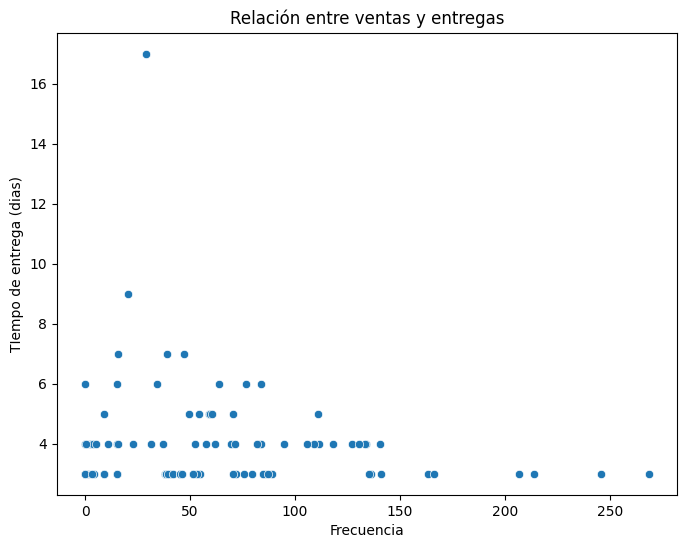

In [206]:
# Visualización de la relación entre el ventas y entregas de los 100 clientes mas frecuentes.

frecuencia_promedio3 = frecuencia_promedio2.head(100)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='prom_frecuencia', y='order_count', data=frecuencia_promedio3)
plt.title('Relación entre ventas y entregas')
plt.xlabel('Frecuencia')
plt.ylabel('TIempo de entrega (dias)')
plt.show()

# Análisis de popularidad de productos por categoría

● Utilizando los datos de las tablas products y order_items.

● Agrupar los productos por categoría y calcular la cantidad total de unidades vendidas para cada categoría. (se muestran las 10 primeras)

In [218]:
categoria_mas_vendida_query = '''
     SELECT p.product_category_name, count(oi.product_id) AS cantidad_total
     FROM Products p
     JOIN order_items oi ON p.product_id = oi.product_id
     GROUP BY p.product_category_name
     ORDER BY cantidad_total DESC
     LIMIT 10
 '''
categoria_mas_vendida = pd.read_sql_query(categoria_mas_vendida_query, conn)
categoria_mas_vendida

,product_category_name,cantidad_total
0,cama_mesa_banho,11115
1,beleza_saude,9670
2,esporte_lazer,8641
3,moveis_decoracao,8334
4,informatica_acessorios,7827
5,utilidades_domesticas,6964
6,relogios_presentes,5991
7,telefonia,4545
8,ferramentas_jardim,4347
9,automotivo,4235


In [219]:
categoria_mas_vendida.to_csv('categoria_mas_vendida.csv', index=False)

● **Generar un informe que muestre las categorías de
productos más populares en términos de ventas.**

En el grafico a continuacion se muestran las primeras 10 categorías de productos más vendidos. En primer lugar se encuentra el mobiliario para el hogar, siendo la unica categría que supera las 10.000 ventas; seguido de salud/belleza y a continuación deportes/placer. Esto indica que quienes comprar pueden ser persnas que les gusta estar comodas en su hogar y se preocupan por su apariencia.
Recomendaría analizar donde se encuentran distribuidas estas tres areas en la tienda y poner algun producto de categorias menos vendidas a su alrededor.

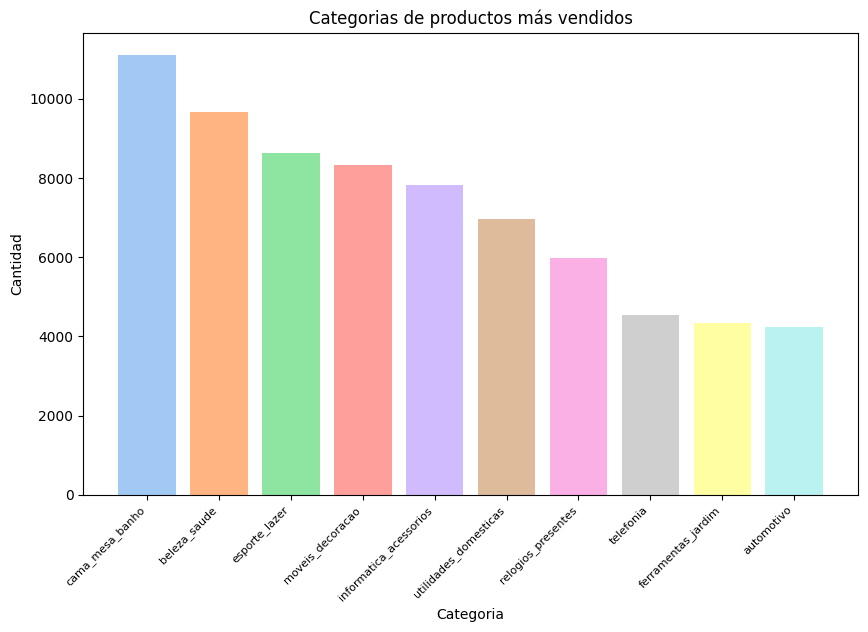

In [145]:
data_grafico = categoria_mas_vendida.sort_values(by='cantidad_total')
palette_color = sns.color_palette('pastel')

plt.figure(figsize=(10, 6))
plt.bar(categoria_mas_vendida['product_category_name'], categoria_mas_vendida['cantidad_total'], color=palette_color)
plt.title('Categorias de productos más vendidos')
plt.xlabel('Categoria')
plt.ylabel('Cantidad')
plt.xticks(rotation=45,ha='right', fontsize=8)
plt.grid(False)
plt.show()

# Análisis de la satisfacción del cliente basado en la velocidad de entrega

● Utilizando datos de las tablas customers y orders.

● Calcula el tiempo promedio de entrega de los pedidos por cliente.

In [ ]:
promedio_entrega_query = '''
SELECT
  o.customer_id, AVG(julianday(o.order_delivered_customer_date)-julianday(o.order_purchase_timestamp)) AS promedio_entrega
FROM orders o
WHERE o.order_delivered_customer_date IS NOT NULL
GROUP BY o.customer_id
order by promedio_entrega DESC;

'''
promedio_entrega = pd.read_sql_query(promedio_entrega_query, conn)
promedio_entrega

In [ ]:
promedio_entrega.to_csv('tiempo promedio entrega por cliente.csv', index=False)

● Genera un informe que muestre los clientes con los
tiempos de entrega más rápidos y más lentos.

Para el presente analisis tomamos los 10 datos de entregas más rápidas y los 10 mas lentas, detectamos una diferencia muy grande ellos. Los pedidos más rápidos se realizaron en el mismo dia, mientras que los más demoraron más de 175 días. Deberiamos analizar en profundidad para saber a que productos corresponde y si son plazos normales de entrega para esas categorias de producto o no.

<Figure size 1000x600 with 0 Axes>

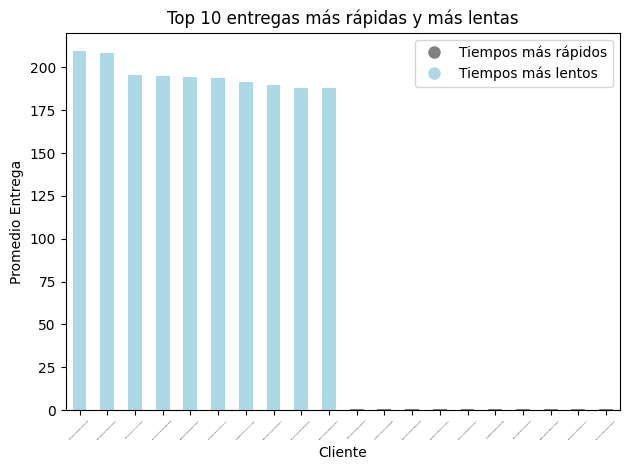

In [125]:
grafico_entrega_maximo = promedio_entrega.head(10)
grafico_entrega_minimo = promedio_entrega.tail(10)
grafico_entrega = pd.merge(grafico_entrega_maximo,grafico_entrega_minimo, how='outer')
grafico_entrega

colors = ['lightblue' if promedio_entrega > 1 else 'grey' for promedio_entrega in grafico_entrega['promedio_entrega']]

plt.figure(figsize=(10,6))
bars = grafico_entrega.plot(kind='bar', x='customer_id', y ='promedio_entrega', color=colors)
plt.title('Top 10 entregas más rápidas y más lentas')
plt.xlabel('Cliente')
plt.ylabel('Promedio Entrega')
plt.legend(['Más rapido','Mas lento'])
plt.xticks(rotation=45,fontsize=1)
plt.tight_layout()


slow_patch = plt.Line2D([0],[0], marker='o',color='w', label='Tiempos más lentos', markersize=10, markerfacecolor='lightblue')
fast_patch = plt.Line2D([0],[0], marker='o',color='w', label='Tiempos más rápidos', markersize=10, markerfacecolor='grey')
plt.legend(handles=[fast_patch, slow_patch])

plt.show()

# Analizar el rendimiento de los métodos de pago utilizados por los clientes

● Utilizar datos de los archivos customers y
order_payments.

● Agrupar los pagos por método de pago y calcula el total de pagos realizados con cada método. (se realizo conteo monetario del total de pagos)

In [ ]:
metodo_pago_query = '''
SELECT
  op.payment_type, ROUND(SUM(op.payment_value), 2) AS total_pagos, count(op.payment_value) as cantidad
FROM order_payments op
WHERE op.payment_value >0
GROUP BY op.payment_type
ORDER BY total_pagos DESC;

'''
metodo_pago = pd.read_sql_query(metodo_pago_query, conn)
metodo_pago


In [220]:
metodo_pago.to_csv('metodo_pago_ventas.csv', index=False)

● Generar un informe que muestre los métodos de pago más utilizados por los clientes.

Se puede analizar que más del 75% de lo facturado proviene de ventas realizadas con tarjeta de crédito, lo que nos indica que nuestros clientes están bancarizados.
Aún tenemos un segmento de casi el 18% que utiliza boleto, es decir, no bancarizado. Habria que realizar analisis etario de los clientes y locación de compra para tener mayor información de las promociones a ofrecer.

In [85]:
import matplotlib.pyplot as plt

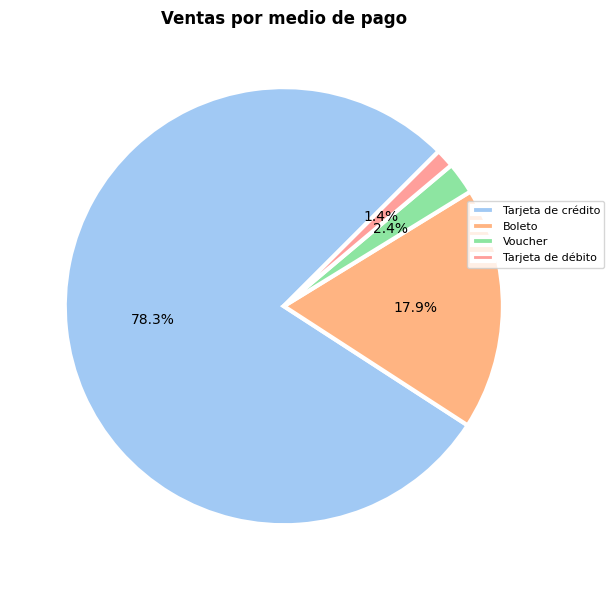

In [210]:
x = metodo_pago['total_pagos']
labels = ['Tarjeta de crédito', 'Boleto', 'Voucher', 'Tarjeta de débito']
palette_color = sns.color_palette('pastel')
explode = (0.1, 0, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(x, autopct='%.1f%%',colors=palette_color, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, startangle=45)
ax.set_title('Ventas por medio de pago', fontweight="bold")
plt.legend(loc='lower center', labels=labels, bbox_to_anchor=(0.96,0.56), ncol=1, fontsize=8)
plt.tight_layout()